In [1]:
import numpy as np
import matplotlib.pyplot as plt
from plotsiii import plotiii1, plotiii2
from plotsv import plotv1, plotv2
from functions import read_data, joint_log_prob_x, joint_log_prob_I
from MCMCSampler import MCMCSampler
from corner import corner
import tensorflow as tf
import tensorflow_probability as tfp
import corner

tdf = tfp.distributions

# set seed
np.random.seed(120420)
tf.random.set_seed(120420)

# read text file
file_path = 'lighthouse_flash_data.txt'

In [2]:
# observed flashes
x_observed = np.array(read_data(file_path)[0], dtype=np.float32)

# Constants for the uniform prior
alpha_range = -3, 2  # Bounds for alpha
beta_range = 0.00001, 5  # Bounds for beta

def unnormalized_posterior(alpha, beta):
    return joint_log_prob_x(x_observed, alpha_range, beta_range, alpha, beta)

# Parameters for the MCMC sampler
target_log_prob_fn = unnormalized_posterior
num_chains = 8
step_size = 0.01
num_burnin_steps = 10
num_results = 30000

initial_alpha = tf.random.uniform([num_chains, 1], minval=alpha_range[0], maxval=alpha_range[1])  # Shape [num_chains, 1]
initial_beta = tf.random.uniform([num_chains, 1], minval=beta_range[0], maxval=beta_range[1])  # Shape [num_chains, 1]
initial_state = [initial_alpha, initial_beta]

In [4]:
mcmc_sampler = MCMCSampler(target_log_prob_fn, num_chains, step_size, num_burnin_steps, num_results, initial_state)

samples, kernel_results = mcmc_sampler.run_chain()
alpha_samples, beta_samples = samples

2024-03-14 15:26:20.109196: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [5]:
# Assuming alpha_samples and beta_samples are defined and have the shape (50000, 8, 1)
combined_samples = tf.concat([alpha_samples, beta_samples], axis=-1)
combined_samples

from zeus import AutoCorrTime

taus = AutoCorrTime(np.array(combined_samples))
print('Autocorrelation:', taus)

tau = max(taus)
print(f"{tau = }")

Autocorrelation: [20.47429466 33.98477554]
tau = 33.98477554321289


In [6]:
ess = tfp.mcmc.effective_sample_size(combined_samples)

# `ess` will be a Tensor of the same shape as a single sample (the '...' part),
# containing the ESS for each parameter (or dimension of the sample space).

# To evaluate and print the ESS values, you might need to convert them to numpy arrays
# if you're not using eager execution in TensorFlow
ess_numpy = ess.numpy()
print("Effective Sample Size:\n", ess_numpy)

aggregated_ess = tf.reduce_sum(ess, axis=0)

# `aggregated_ess` will now be a 1D tensor with the aggregated ESS for each parameter
print("Aggregated Effective Sample Size for each parameter:\n", aggregated_ess.numpy())

Effective Sample Size:
 [[1482.6141   524.4707 ]
 [1053.9076   897.7278 ]
 [1180.2078   730.57245]
 [1498.8585   981.7282 ]
 [1427.6653   978.85455]
 [1269.849    858.2932 ]
 [2406.8894  1458.3674 ]
 [1281.3169  1135.4183 ]]
Aggregated Effective Sample Size for each parameter:
 [11601.309  7565.433]


In [7]:
alpha_flat = alpha_samples.numpy().squeeze()  # This changes shape from (300, 1, 1) to (300,)
beta_flat = beta_samples.numpy().squeeze()  # Same here

# Stack alpha and beta samples along a new axis to get the correct shape
samples_np = np.stack([alpha_flat, beta_flat], axis=-1)  # This should give you a shape of (300, 2)

# mean and std of alpha and beta
mean_alpha = np.mean(alpha_samples)
std_alpha = np.std(alpha_samples)

mean_beta = np.mean(beta_samples)
std_beta = np.std(beta_samples)

print('alpha:', mean_alpha, std_alpha)
print('beta:', mean_beta, std_beta)

alpha: -0.49982268 0.3465137
beta: 1.7126154 0.36004156


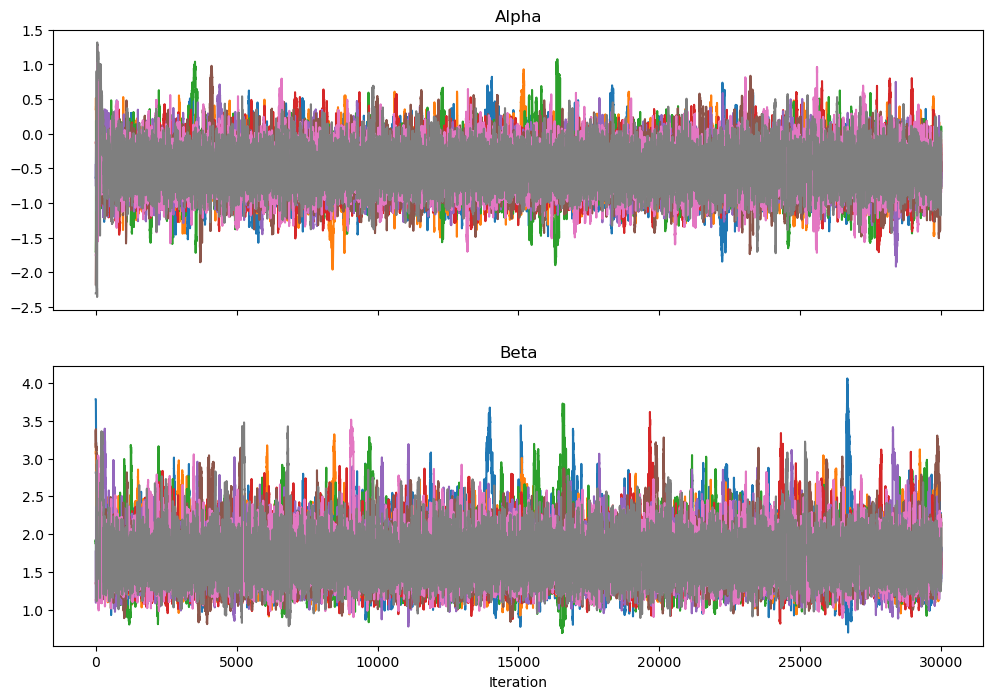

In [8]:
# plot alpha and beta samples
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12, 8))
axes[0].plot(alpha_flat)
axes[0].title.set_text('Alpha')
axes[1].plot(beta_flat)
axes[1].title.set_text('Beta')
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('')


plt.show()


/Users/maxtalberg/miniconda3/envs/S2-env/lib/python3.8/site-packages/arviz/data/base.py:169: UserWarning: More chains (30000) than draws (8). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


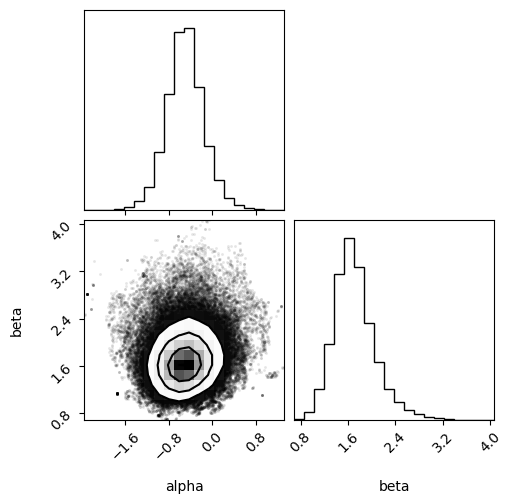

In [9]:
corner.corner(samples_np, labels=['alpha', 'beta'])
plt.show()


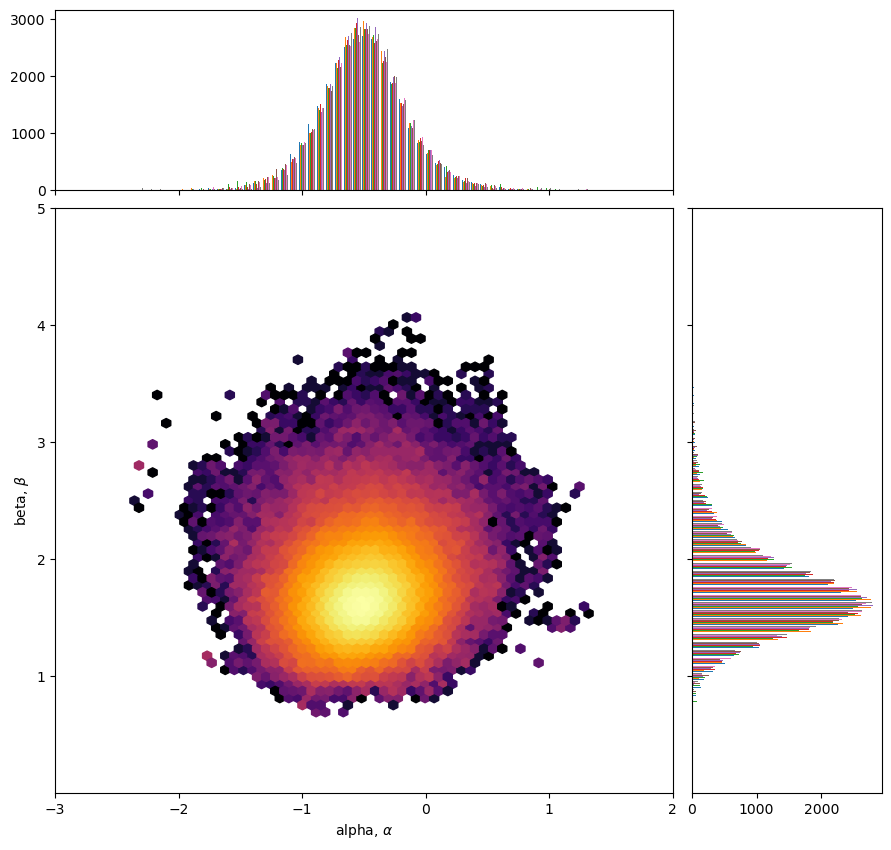

In [10]:
samples_flat = alpha_flat, beta_flat
plotv1(samples_flat, alpha_range, beta_range)

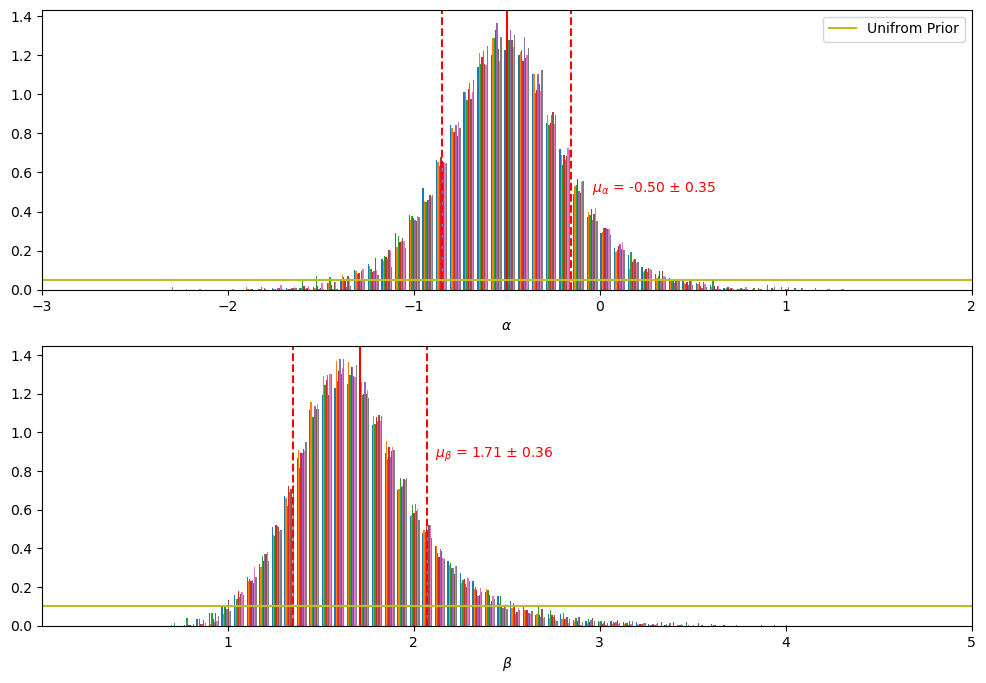

In [11]:
plotv2(samples_flat, alpha_range, beta_range)

In [3]:
hmc_kernel_results = kernel_results


r_hat = tfp.mcmc.potential_scale_reduction(samples)
print("Acceptance rate:", hmc_kernel_results.is_accepted.numpy().mean())
r_hat_numpy = [tensor.numpy() for tensor in r_hat]

# Now you can print the r_hat values
print("R-hat diagnostic (per latent variable):", r_hat_numpy)


NameError: name 'kernel_results' is not defined

In [47]:
# observed flashes
I_observed = np.array(read_data(file_path)[1], dtype=np.float32)

# Constants for the uniform prior
a = tf.cast(-1, tf.float32) # -3
b = tf.cast(1, tf.float32) # 2
c = tf.cast(0.5, tf.float32)
d = tf.cast(2, tf.float32)
e = tf.cast(0.5, tf.float32)
f = tf.cast(6, tf.float32)  
alpha_range = a, b
beta_range = c, d
I_range = e, f

def unnormalized_posterior(alpha, beta, I0):
    log_prob_x = joint_log_prob_x(x_observed, alpha_range, beta_range, alpha, beta)
    log_prob_I = joint_log_prob_I(x_observed, I_range, I_observed, alpha, beta, I0)
    return log_prob_x + log_prob_I

# Parameters for the MCMC sampler
target_log_prob_fn = unnormalized_posterior
num_chains = 8
step_size = 0.01
num_burnin_steps = 100
num_results = 1000

initial_alpha = tf.random.uniform([num_chains, 1], minval=alpha_range[0], maxval=alpha_range[1])  # Shape [num_chains, 1]
initial_beta = tf.random.uniform([num_chains, 1], minval=beta_range[0], maxval=beta_range[1])  # Shape [num_chains, 1]
initial_I0 = tf.random.uniform([num_chains, 1], minval=I_range[0], maxval=I_range[1])  # Shape [num_chains, 1]

initial_state = [initial_alpha, initial_beta, initial_I0]


In [48]:
mcmc_sampler = MCMCSampler(target_log_prob_fn, num_chains, step_size, num_burnin_steps, num_results, initial_state)

samples, kernel_results = mcmc_sampler.run_chain()
alpha_samples, beta_samples, I0_samples = samples

In [49]:
alpha_flat = alpha_samples.numpy().squeeze()  # This changes shape from (300, 1, 1) to (300,)
beta_flat = beta_samples.numpy().squeeze()  # Same here
I0_flat = I0_samples.numpy().squeeze()  # Same here

# Stack alpha and beta samples along a new axis to get the correct shape
samples_np = np.stack([alpha_flat, beta_flat, I0_flat], axis=-1)  # This should give you a shape of (300, 2)

# mean and std of alpha and beta and I0
mean_alpha = np.mean(alpha_samples)
std_alpha = np.std(alpha_samples)

mean_beta = np.mean(beta_samples)
std_beta = np.std(beta_samples)

mean_I0 = np.mean(I0_samples)
std_I0 = np.std(I0_samples)

print('alpha:', mean_alpha, std_alpha)
print('beta:', mean_beta, std_beta)
print('I0:', mean_I0, std_I0)

alpha: 0.070491776 0.5215075
beta: 1.3133836 0.36574584
I0: 2.7316384 1.6266798


In [50]:
hmc_kernel_results = kernel_results


r_hat = tfp.mcmc.potential_scale_reduction(samples)
print("Acceptance rate:", hmc_kernel_results.is_accepted.numpy().mean())
r_hat_numpy = [tensor.numpy() for tensor in r_hat]

# Now you can print the r_hat values
print("R-hat diagnostic (per latent variable):", r_hat_numpy)

Acceptance rate: 0.19775
R-hat diagnostic (per latent variable): [array([12.219597], dtype=float32), array([11.148105], dtype=float32), array([29.818674], dtype=float32)]


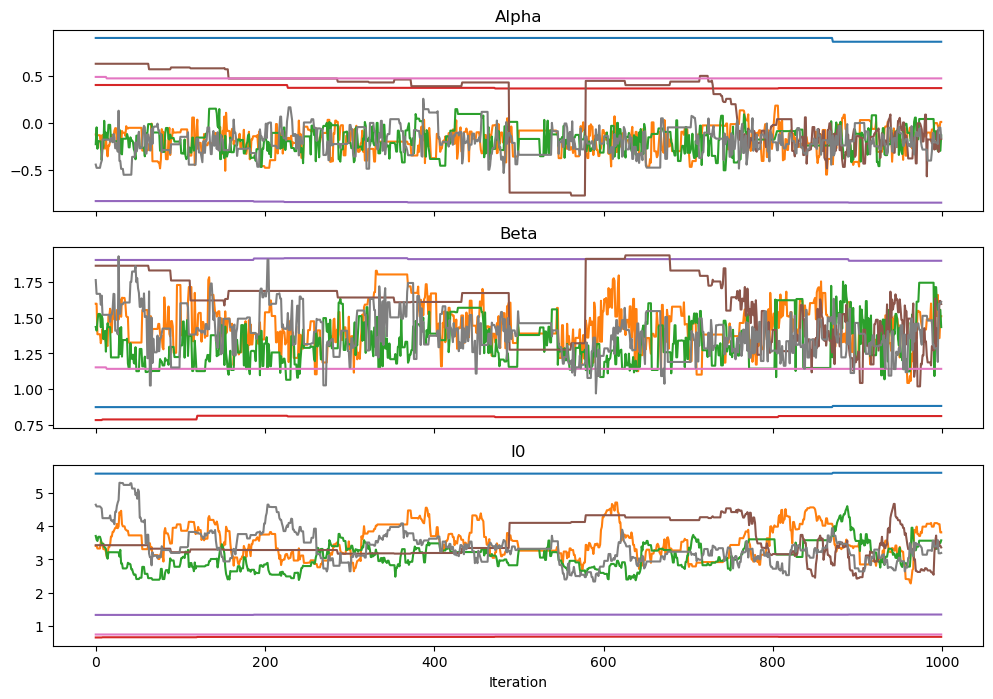

In [51]:
# plot alpha and beta samples
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(12, 8))
axes[0].plot(alpha_flat)
axes[0].title.set_text('Alpha')
axes[1].plot(beta_flat)
axes[1].title.set_text('Beta')
axes[1].set_ylabel('')
axes[2].plot(I0_flat)
axes[2].title.set_text('I0')
axes[2].set_xlabel('Iteration')


plt.show()


/Users/maxtalberg/miniconda3/envs/S2-env/lib/python3.8/site-packages/arviz/data/base.py:169: UserWarning: More chains (1000) than draws (8). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


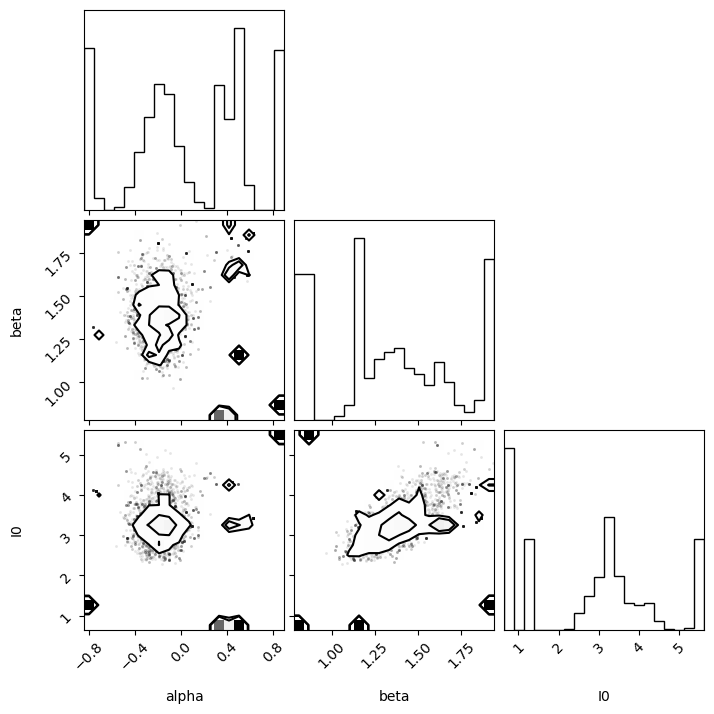

In [52]:
corner.corner(samples_np, labels=['alpha', 'beta', 'I0'])
plt.show()
